In [1]:
import matplotlib.pyplot as plt
import pyvista
import ufl
import numpy as np
from tqdm.notebook import tqdm
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from petsc4py import PETSc
from mpi4py import MPI


from dolfinx import fem, mesh, io, plot
from dolfinx.fem.petsc import assemble_vector, assemble_matrix, create_vector, apply_lifting, set_bc

# Define temporal parameters
t = 0  # Start time
T = 10000.0  # Final time
num_steps = 1000
dt = T / num_steps  # time step size

# Define mesh
nx, ny = 50, 50
domain = mesh.create_rectangle(MPI.COMM_WORLD, [np.array([-2, -2]), np.array([2, 2])],
                               [nx, ny], mesh.CellType.triangle)
V = fem.FunctionSpace(domain, ("Lagrange", 1))

In [2]:
# Create initial condition
def initial_condition(x, a=5):
    return np.exp(-a * (x[0]**2 + x[1]**2))


u_n = fem.Function(V)
u_n.name = "u_n"
u_n.interpolate(initial_condition)

# Create boundary condition
fdim = domain.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(
    domain, fdim, lambda x: np.full(x.shape[1], True, dtype=bool))

OutsideTemp = fem.Constant(domain,0.0)
bc = fem.dirichletbc(OutsideTemp, fem.locate_dofs_topological(V, fdim, boundary_facets), V)

In [3]:
maxtemp = 300.0
temp0 = 0.0
def TempRamp(t):
    if t < T/2:
        return maxtemp*t/(T/2)
    else:
        return np.max([temp0, maxtemp*(1-(t-T/2)/(T/2))])

In [4]:
xdmf = io.XDMFFile(domain.comm, "diffusion.xdmf", "w")
xdmf.write_mesh(domain)

# Define solution variable, and interpolate initial solution for visualization in Paraview
uh = fem.Function(V)
uh.name = "uh"
uh.interpolate(initial_condition)
xdmf.write_function(uh, t)

In [5]:
v = ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))

Res = uh * v * ufl.dx + dt * ufl.dot(ufl.grad(uh), ufl.grad(v)) * ufl.dx - (u_n + dt * f) * v * ufl.dx

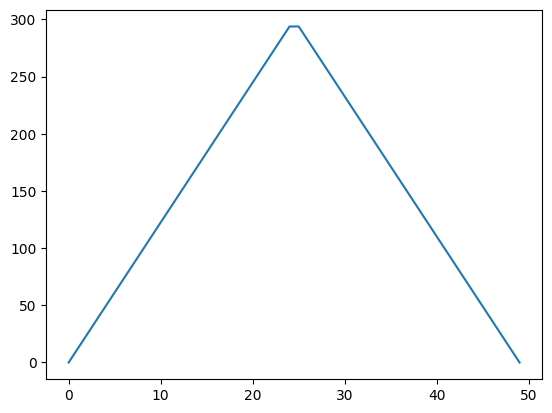

In [6]:
#Make it nonlinear see if it breaks
import matplotlib.pyplot as plt
plt.plot(list(map(TempRamp,np.linspace(0,T))))


In [7]:


problem = NonlinearProblem(Res, uh, [bc])
solver = NewtonSolver(MPI.COMM_WORLD, problem)

In [8]:
for i in range(num_steps):
    t += dt

    # Update the right hand side reusing the initial vector

    # Apply Dirichlet boundary condition to the vector
    OutsideTemp.value = TempRamp(t)
    if(i%10 ==0):
        print(t)
    # Solve linear problem
    solver.solve(uh)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array

    # Write solution to file
    xdmf.write_function(uh, t)
    # Update plot
    
xdmf.close()

100.0
1100.0
2100.0
3100.0
4100.0
5100.0
6100.0
7100.0
8100.0
9100.0
